# Computational Finance

## Lab Assignment 1

Authors:
- Kevin de Vries
- Jed Boyle
- Krishnakanth Sasi

Student numbers:
- 10579869
- 00000000
- 11391952

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import norm

# Part 1: Option valuation

In [10]:
def payoff(S,K,call):
    '''
    Calculates the payoff of an option layer
    '''
    
    f = S - K if call else K - S
    f[f < 0] = 0
    return f

def option_valuation(S0,K,T,N,r,v,call=True,american=False):
    '''
    Calculates the option valuation from a given node.
    
    Parameters
        S0: float
            Current stock price
        K: float
            Strike price
        T: float
            Maturity of the option
        N: int
            Number of time steps
        r: float
            Interest rate
        v: float
            Volatility
        call: Bool
            Determines if option is a call or a put
        american: Bool
            Determines if option is American of European
        
    Returns
        f: float
            Option valuation
        delta: float
            Hedge parameter
    '''
    
    # Time step length
    dt = T / N
    
    # Calculate tree parameters
    u = np.exp(v * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Stock prices at expiration
    S = S0 * u**(np.arange(0,N+1) - np.arange(0,N+1)[::-1])
    
    # Call option value at expiration
    f = payoff(S,K,call)
    
    for i in range(N-1):
        f = np.exp(-r*dt) * (p*f[1:N-i+1] + (1-p)*f[0:N-i])
        
        # American option can be exercised before maturity.
        # The highest possible payoff per node is thus considered risk neutral.
        if american:
            S = S0 * u**(np.arange(0,N-i) - np.arange(0,N-i)[::-1])
            f_potential = payoff(S,K,call)
            f = np.maximum(f,f_potential)
            
    delta = (f[1]-f[0]) / (S0*(u-d))
    f = np.exp(-r*dt) * (p*f[1] + (1-p)*f[0])
    
    return f, delta

# Black Scholes formula

def blackScholes(r, K, T, S_0, sigma):
    '''
    Calculates the Hedge ratio, call price and put price
    
    Parameters
        r: float
            Interest rate
        K: float
            Strike price
        T: int
            Time of maturity
        S_0: float
            Current stock price
        sigma: float
            Volatility
        
    Returns
        N1: float
            Hedge ratio
        c: float
            Call price
        p: float
            Put price
    '''
    d1 = (math.log(S_0/K)+(r+(sigma**2)/2)*T)/sigma*(T**0.5)
    d2 = d1-sigma*(T**0.5)
    N1 = norm.cdf(d1)
    N2 = norm.cdf(d2)
    N3 = norm.cdf(-d1)
    N4 = norm.cdf(-d2)
    c = S_0*N1 - K*math.exp(-r*T)*N2
    p = K*math.exp(-r*T)*N4 - S_0*N3
    return N1, c, p 

In [11]:
# Test option valuation on the example in the slides

f,delta = option_valuation(50,50,5/12,5,0.1,0.4,call=False)
print(f)
print(delta)

4.31901871652
-0.393051801205


In [12]:
# Test option valuation on the initial parameters in the assignment
# Analytical value of valuation was supposedly ~11.4 according to the lecturer

cur, strike = 100.0, 99
volatility, interest = 0.2, 0.06
maturity, steps = 1, 50

f,delta = option_valuation(cur,strike,maturity,steps,interest,volatility)

print(f)
print(delta)

11.5464348508
0.672556964605


In [13]:
# Test option valuation on the initial parameters in the assignment using American option

cur, strike = 100.0, 99.0
volatility, interest = 0.2, 0.06
maturity, steps = 1, 50

f,delta = option_valuation(cur,strike,maturity,steps,interest,volatility,call=False,american=True)

print(f)
print(delta)

5.34776349842
-0.382039156259


In [14]:
r = 0.06 # interest rate
K = 99 # strike price
T = 1 # time of maturity
S_0 = 100 # current stock price
sigma = 0.2 # volatility

hedgeRatio, callPrice, putPrice =  blackScholes(r, K, T, S_0, sigma) #returns the analytic values 

print("Hedge ratio is %f" % hedgeRatio)
print("Call price is %f" % callPrice)

Hedge ratio is 0.673736
Call price is 11.544280


# Part 2: Hedging Simulations

In [15]:
def stock_price(S_0, N, r = .06, sigma = .2, T = 1):
    delta_t = T / N
    S = np.zeros(N+1)
    dZ = np.sqrt(delta_t) * np.random.normal(0,1,N+1)
    S[0] = S_0
    for i in range(1, N+1):
        S[i] = S[i-1] + r * S[i-1] * delta_t + sigma * S[i-1] * dZ[i]
    
    return S

def hedge_ratios(S, N, r = .06, sigma = .2, K = 99, T = 1):
    T_i = T - T / N * np.arange(N)
    d1 = np.log(S[:N]/K) + T_i * (r + ((sigma**2) /2)) / (sigma * np.sqrt(T_i))
    hedge_ratios = norm.cdf(d1)
    return hedge_ratios

def dynamic_hedging(S, deltas, N, r = .06, sigma = .2, K = 99, T = 1):
    '''
    Applies a dynamic hedging strategy to a stock price simulation
    using pre-calculated hedge parameters.
    
    Starts by selling the call and taking a position in the underlying
    by buying a delta amount of shares. Reacts to the stock price changes
    by assuring a delta amount of shares at each time step through selling 
    and buying shares as needed. At time T, the option is exercised (or not)
    and any leftover shares are sold back to the market.
    
    Useful literature:
    https://esc.fnwi.uva.nl/thesis/centraal/files/f1843690389.pdf
    https://nms.kcl.ac.uk/john.armstrong/courses/fm06/book/matlab-chapter6.pdf
    
    Parameters
        S: numpy ndarray
            Stock prices at each time step
        deltas: numpy ndarray
            Hedge parameters at each time step except T
        N: int
            Number of time steps
        r: float
            Interest rate
        sigma: float
            Volatility
        K: float
            Strike price
        T: int
            Time of maturity
    
    Returns
        b: numpy ndarray
            Cash balance at each time step
    '''
    
    dt = T / N
    b = np.zeros(N+1)
    
    _,c,_ = blackScholes(r, K, T, S[0], sigma)
    
    b[0] = c - deltas[0]*S[0]
    for i in range(1,N):
        b[i] = np.exp(r*dt) * b[i-1] - (deltas[i] - deltas[i-1]) * S[i]
    
    b[N] = np.exp(r*dt) * b[N-1] + deltas[N-1] * S[N] - max(0, S[N] - K)
    return b

Mean profit: 0.025995


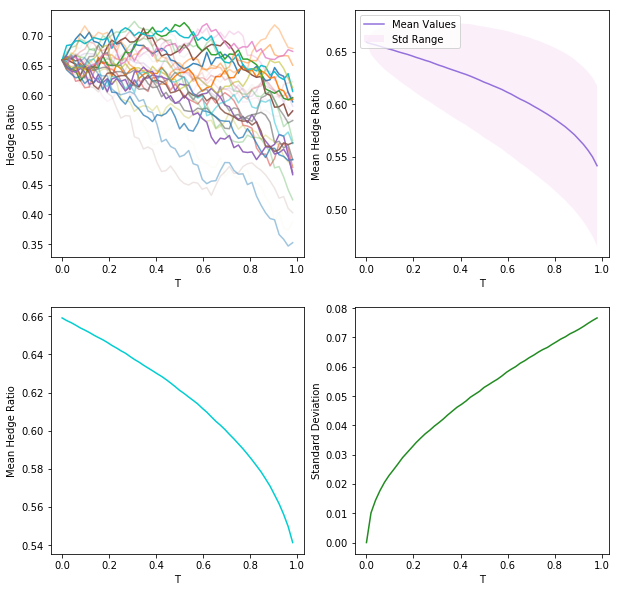

In [17]:
'''
Set parameters.
'''
T = 1
N = 52
r = .06
K = 99
S_0 = 100
stock_price_volatility = .2
option_valuation_volatility = .2
num_simulations = 5000

'''
Run simulations.
'''
# Each row is one simulation of the stock price.
stock_prices = np.zeros((num_simulations, N+1))

# Each row is one simulation of the hedge parameter. 
deltas = np.zeros((num_simulations, N))

# Run simultations and store results.
for i in range(num_simulations):
    stock_prices[i] = stock_price(S_0, N, r, stock_price_volatility, T)
    deltas[i] = hedge_ratios(stock_prices[i], N, r, option_valuation_volatility, K, T)


balances = np.zeros((num_simulations, N+1))
for i in range(num_simulations):
    balances[i] = dynamic_hedging(stock_prices[i], deltas[i], N, r, option_valuation_volatility, K, T)

mean_profit = np.mean(balances[:,N])
print("Mean profit: %f" % mean_profit)

# Compute simulations summay statistics.
mean_values = np.mean(deltas, axis = 0)
std_values = np.std(deltas, axis = 0)

'''
Plot the results.
'''
x_axis = np.arange(N) * T / N
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.xlabel('T')
plt.ylabel('Hedge Ratio')
for i in range(1, 30):
    plt.plot(x_axis, deltas[i], alpha = 30/i)

plt.subplot(2, 2, 2)
plt.xlabel('T')
plt.ylabel('Mean Hedge Ratio')
plt.plot(x_axis, mean_values, color="mediumpurple", label ='Mean Values')
plt.fill_between(x_axis, mean_values - std_values, mean_values + std_values, facecolor='orchid', alpha=.1, label ='Std Range')
plt.legend(loc='upper left')
plt.subplot(2, 2, 3)
plt.xlabel('T')
plt.ylabel('Mean Hedge Ratio')
plt.plot(x_axis, mean_values, color='darkturquoise')
plt.subplot(2, 2, 4)
plt.xlabel('T')
plt.ylabel('Standard Deviation')
plt.plot(x_axis, std_values, color='forestgreen')
plt.show()